In [1]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import venn
import os 

%matplotlib inline

# Insert the titles of the graph
filename = "Orthofinder_results"

# Insert the path to graphs folder (destination)
path = '../results/' + 'Orthofinder-results-plot/pipiens_pallens_quinquefasciatus_aegypti_gambiae/OrthoFinder'

orthofinder_dir_path    = 'Orthofinder-results-plot/pipiens_pallens_quinquefasciatus_aegypti_gambiae/OrthoFinder/Results_Jun11'
orthogroups_dir_path    = orthofinder_dir_path + '/Orthogroups'
orthologues_dir_path    = orthofinder_dir_path + '/Orthologues'
genomics_stats_dir_path = orthofinder_dir_path + '/Comparative_Genomics_Statistics'
species_tree_dir_path   = orthofinder_dir_path + '/Species_Tree'

# Getting the file names
stats_per_species       = genomics_stats_dir_path + '/Statistics_PerSpecies.tsv'
orthogroups_file        = orthogroups_dir_path    + '/Orthogroups.tsv'
orthologues_many_many   = genomics_stats_dir_path + '/OrthologuesStats_many-to-many.tsv'
orthologues_many_one    = genomics_stats_dir_path + '/OrthologuesStats_many-to-one.tsv'
orthologues_one_many    = genomics_stats_dir_path + '/OrthologuesStats_one-to-many.tsv'
orthologues_one_one     = genomics_stats_dir_path + '/OrthologuesStats_one-to-one.tsv'
species_tree_file       = species_tree_dir_path   + '/SpeciesTree_rooted.txt'
stats_overall_file      = genomics_stats_dir_path + '/Statistics_Overall.tsv'

# Getting the organism names
organisms = ! head -n 1 $stats_per_species
organisms = organisms[0].split('\t')[1:]

Plotting the Venn diagram of orthogroups

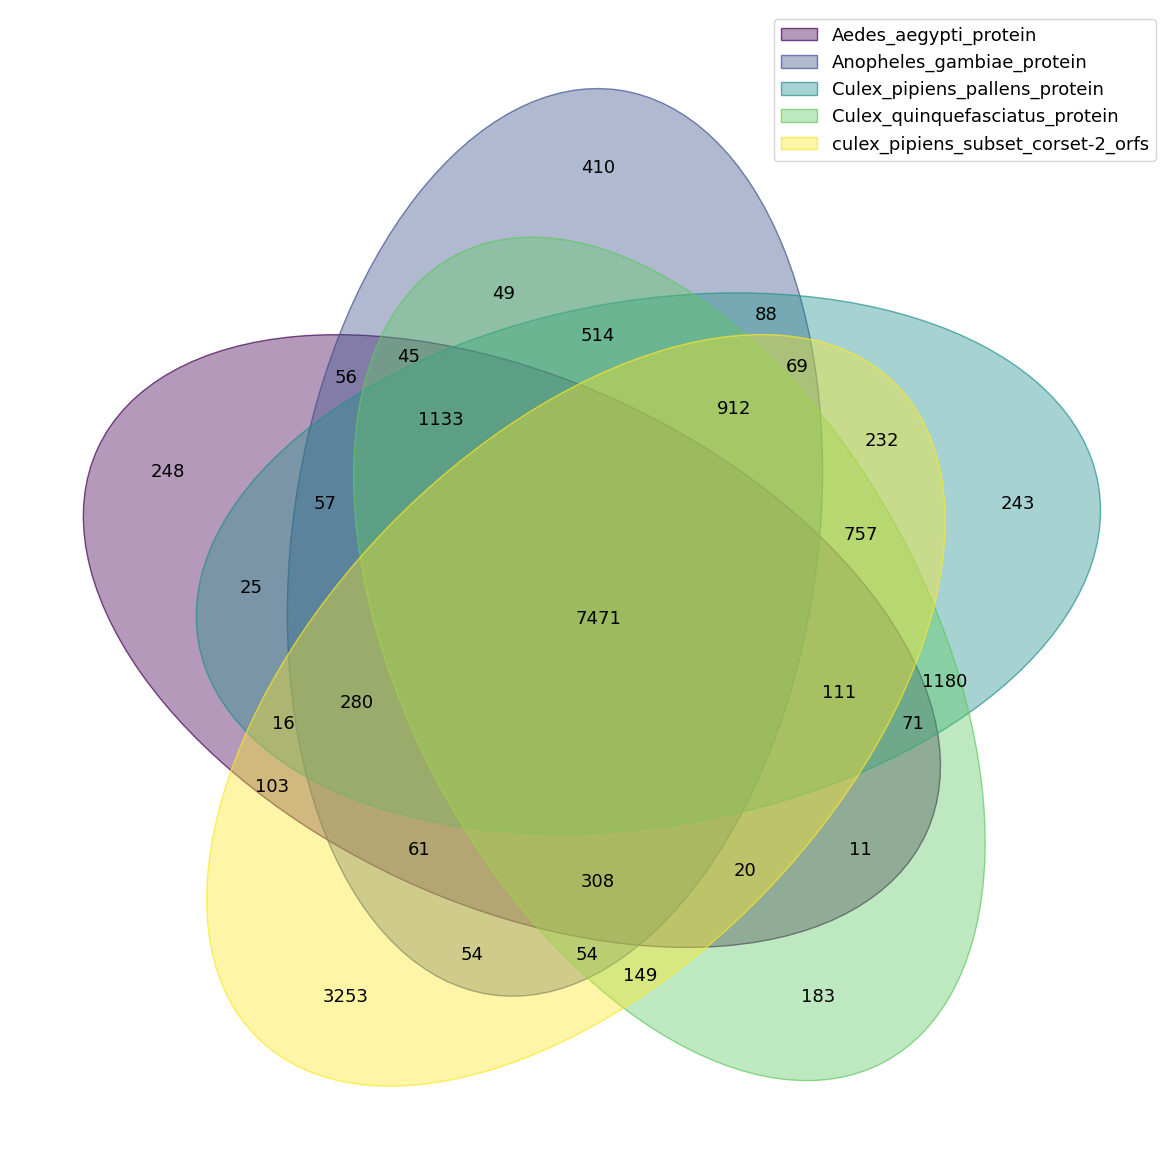

In [2]:
# Take all orthogroups of each organism

df = pd.read_csv(orthogroups_file, sep='\t')
colori = ['red', 'blue', 'green', 'black']
s = {}

for org in organisms:
    s[org] = set(df[df[org].notna()]['Orthogroup'])

venn.venn(s, figsize=(30, 15))
plt.savefig(path + "/" + filename + '_orthogroups_venn.png', bbox_inches = 'tight', dpi=300)
plt.show()

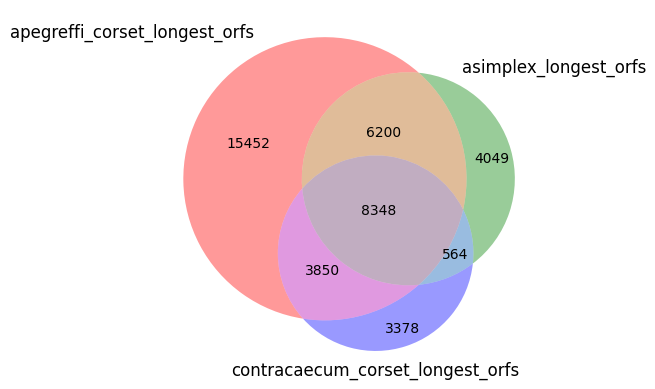

In [4]:
from matplotlib_venn import venn3 
from matplotlib_venn import venn2_unweighted

venn3([s[k] for k in s.keys()], organisms)

plt.savefig(path + "/" + filename + '_orthogroups_venn_weighted.png', bbox_inches = 'tight', dpi=300)
plt.show()

In [8]:
# Function that load the data from files
def load_orthologues(path, dic):
    df = pd.read_csv(path, sep='\t', index_col='Unnamed: 0')
    df = df.T.reset_index()

    for org in organisms:
        dic[org].append(df[org].sum())

# Function that return the summation of percentages
def get_orthologues_percentage(orthologues):

    tot = sum(orthologues)

    orthologues[0] = round(orthologues[0] / tot *100, 2)

    for i in range(1, len(orthologues)-1):
        orthologues[i] = round(orthologues[i] / tot *100 + orthologues[i-1], 2)
    
    orthologues[-1] = 100.0

    
    return orthologues

In [9]:
orthologues_percentage = {}

for org in organisms:
    orthologues_percentage[org] = []

# get data of all multiplicity
load_orthologues(orthologues_one_one,   orthologues_percentage)
load_orthologues(orthologues_one_many,  orthologues_percentage)
load_orthologues(orthologues_many_one,  orthologues_percentage)
load_orthologues(orthologues_many_many, orthologues_percentage)

# get the percentage from multiplicities
for org in organisms:
    orthologues_percentage[org] = get_orthologues_percentage(orthologues_percentage[org])

Plotting the multiplicities graph

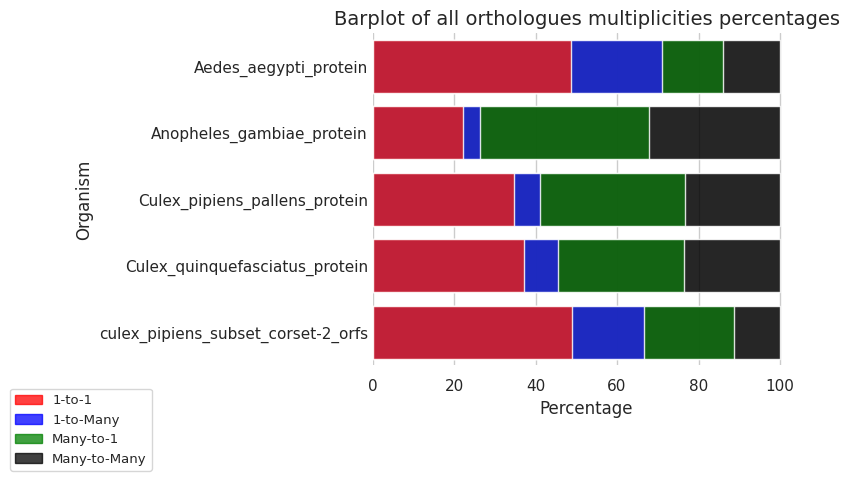

In [10]:
from matplotlib import patches

# Impostazione dello stile di Seaborn
sns.set(style="whitegrid")
colori = ['red', 'blue', 'green', 'black']
molteplicity = ['Many-to-Many', 'Many-to-1', '1-to-Many', '1-to-1'][::-1]

# Creazione del grafico
fig, ax = plt.subplots(figsize=(10, len(organisms)))

# Creazione delle singole barre con colori diversi
for i in range(3, -1, -1):
    sns.barplot(x=[orthologues_percentage[k][i] for k in orthologues_percentage.keys()], color=colori[i], y=organisms, ax=ax, errorbar=None, alpha=0.85)

# Personalizzazione dell'asse x, y e degli spazi dei ticks
ax.set_xlabel('Percentage', fontsize=12)
ax.set_ylabel('Organism', fontsize=12)
ax.set_title('Barplot of all orthologues multiplicities percentages', fontsize=14)

# Rimozione dei bordi del grafico
sns.despine(top=True, right=True, left=True, bottom=True)

# Rimozione dei ticks dell'asse y
ax.tick_params(axis='y', length=0)

# Legenda
patches_list = [patches.Patch(color=colori[i], label=molteplicity[i], alpha=0.75) for i in range(len(molteplicity))]
ax.legend(handles=patches_list, bbox_to_anchor=(-0.5, -0.05), fontsize="9.5")

plt.tight_layout()

plt.savefig(path + "/" + filename + '_orthologues_barplot.png', bbox_inches = 'tight', dpi=300)

plt.show()

Generate the phylogenetic tree

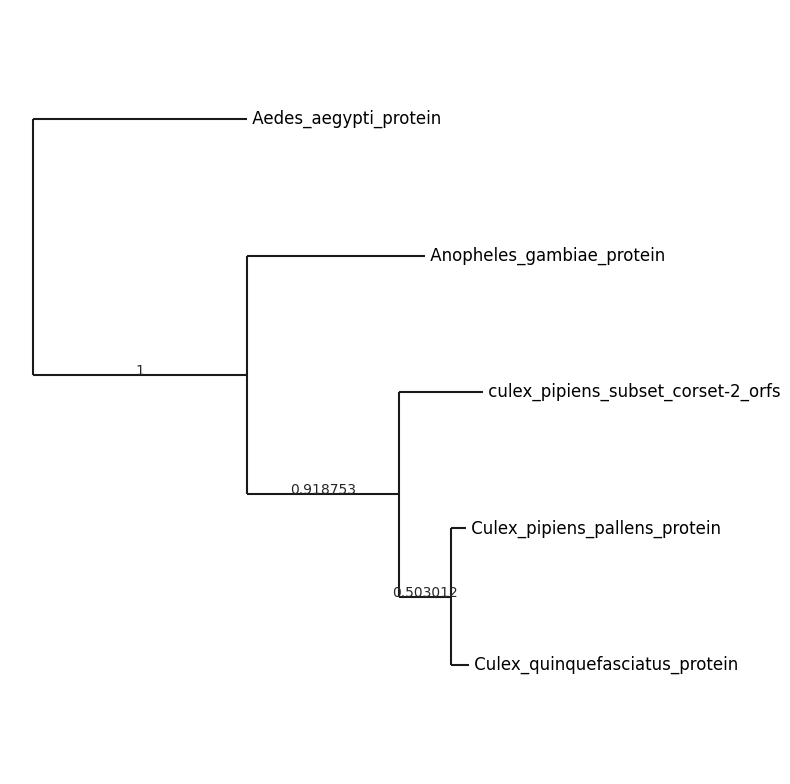

In [11]:
from Bio import Phylo

tree = Phylo.read(species_tree_file, "newick")

# Imposta i parametri per la visualizzazione dell'albero
fig, ax = plt.subplots(figsize=(8, 8))  # Imposta la dimensione della figura
Phylo.draw(tree, axes=ax, do_show=False)  # Passa l'asse e imposta do_show su False

# Rimuovi gli assi e i margini
ax.axis('off')
plt.tight_layout()

plt.savefig(path + "/" + filename + '_phylogenetic_tree.png', bbox_inches = 'tight', dpi=300)

# Mostra solo l'albero
plt.show()

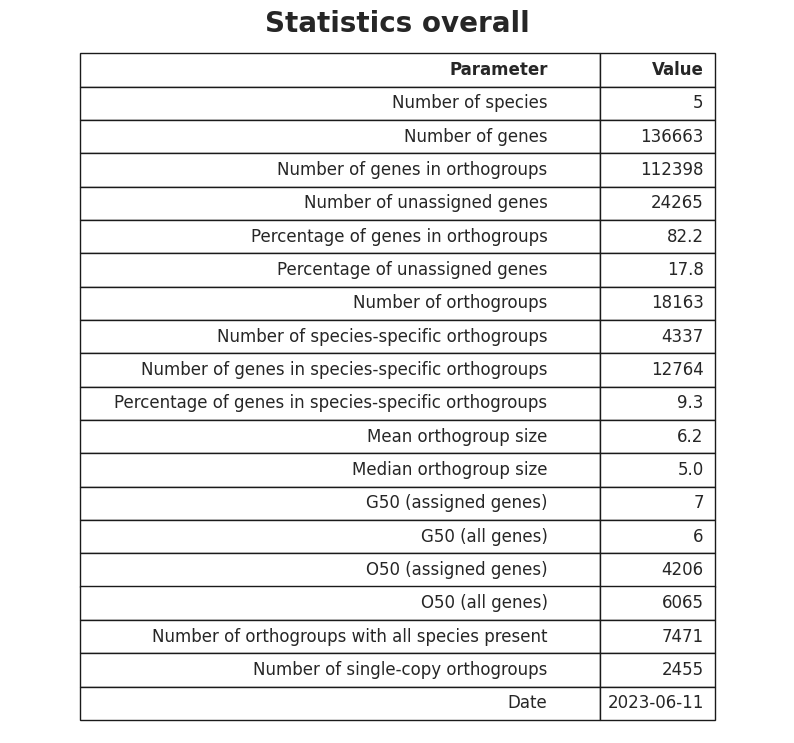

In [12]:
table_data = []
with open(stats_overall_file, 'r') as f:
  for line in f.readlines()[:19]:
    table_data.append(line.split("\t"))
    table_data[-1][1] = table_data[-1][1].strip()

table_data = [['Parameter', 'Value']] + table_data

plt.rcParams["figure.figsize"] = (10,9)
fig, ax = plt.subplots()

table = ax.table(cellText=table_data, loc='center')

table.set_fontsize(34)
table.scale(1, 2)
table.auto_set_column_width(col=list(range(len(table_data[0]))))
ax.set_title("Statistics overall", weight='bold', size=20)

from matplotlib.font_manager import FontProperties

for (row, col), cell in table.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    
ax.axis('off')
plt.savefig(path + "/" + filename + '_stats_table.png', bbox_inches = 'tight', dpi=300)
plt.show()